In [55]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, LeaveOneOut
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy
from tqdm import tqdm
from gtfparse import read_gtf

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from sklearn import svm
from xgboost import XGBRegressor


from sklearn.metrics import root_mean_squared_error as RMSE


In [56]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

# value_to_predict = 'population'
value_to_predict = 'Age'

organ = "HEART"
# organ = "BRAIN0"
organ = "BRAIN1"

sex = 'male'
sex = 'female'

In [57]:
fdir_processed / f'{organ}.preprocessed.h5'

PosixPath('../data/interim/BRAIN1.preprocessed.h5')

In [58]:
gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
gtf_data = gtf_rawdata.to_pandas()
gtf_data = gtf_data.set_index('transcript_id')
gtf_data['transcript_id'] = gtf_data.index

gtf_data

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


In [ ]:
data = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="data")
data_header = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="header")

data = data.iloc[:, np.argwhere(np.sum(data > 0, axis=0) > 18).ravel()]
# data
if organ == "BRAIN1":
    data_header['sex'] = data_header['gender'] 


data = data.loc[data_header['sex'] == sex]
data_header = data_header.loc[data_header['sex'] == sex]



In [ ]:
# eval_organ = "BRAIN0"
# eval_organ = "BRAIN1"
# eval_organ = 'HEART'
eval_organ = organ

fname = next((fdir_external / eval_organ / 'reg').glob("*processed.h5"))
fname = fname.name
data_eval = pd.read_hdf(fdir_external / eval_organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / eval_organ / 'reg' / 'SraRunTable.txt', sep=',')
data_eval_header.set_index("Run", inplace=True)

if eval_organ == "BRAIN1":
    data_eval_header['sex'] = data_eval_header['gender'] 

data_eval_header = data_eval_header.loc[data_eval_header['sex'] == sex]
data_eval = data_eval.loc[(data_eval_header['sex'] == sex).index]


In [ ]:
common_transcripts = data.columns.intersection(data_eval.columns)

data_eval = data_eval[common_transcripts]
data = data[common_transcripts]
data

,ENST00000003912.7,ENST00000004103.8,ENST00000005340.10,ENST00000006658.11,ENST00000011473.6,ENST00000012134.7,ENST00000019019.6,ENST00000040877.2,ENST00000043402.8,ENST00000070846.11,...,MSTRG.9920.54,MSTRG.9929.23,MSTRG.9929.7,MSTRG.993.1,MSTRG.9947.1,MSTRG.9948.7,MSTRG.9968.1,MSTRG.9975.19,MSTRG.9996.5,MSTRG.9996.8
SRR19147435,0.028958,0.000000,0.834745,1.847615,2.891965,1.902646,0.172238,0.695127,0.000000,0.000000,...,0.000000,0.358886,0.158193,1.170810,0.000000,0.395059,0.000000,0.413721,1.591116,0.348319
SRR19147436,0.026559,0.000000,0.543138,0.000000,0.000000,2.253369,0.000000,0.012604,0.080319,1.091911,...,0.000000,0.000000,0.000000,2.064195,0.000000,0.398859,0.403035,0.000000,2.387390,1.570008
SRR19147437,0.048312,0.000000,0.000000,0.000000,0.000000,4.136106,3.016967,0.300410,0.000000,0.562984,...,0.000000,1.130694,0.834678,2.205190,0.534288,0.150727,0.169303,0.000000,2.027091,1.063526
SRR19147438,0.000000,0.000000,0.000000,0.000000,3.418941,0.000000,1.557123,0.000000,0.000000,1.654769,...,1.368054,0.930568,0.554803,0.000000,0.000000,0.155173,0.019762,0.000000,0.000000,0.000000
SRR19147439,0.046003,0.454039,1.029648,2.566160,2.321773,2.573854,0.000000,0.521783,1.571417,0.651481,...,0.208688,0.000000,0.608604,1.677697,0.000000,0.652186,1.153167,0.068222,0.000000,2.014083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR19147641,0.093393,0.000000,0.000000,2.122827,0.000000,2.076210,0.337818,0.106611,0.197119,0.000000,...,0.000000,0.287268,0.101688,0.014515,0.605504,0.297676,0.375136,0.125045,1.844473,0.554188
SRR19147642,0.054792,0.911607,0.690133,2.784186,1.158201,0.000000,0.172868,0.794288,0.130496,0.000000,...,0.000000,0.546777,0.000001,0.791522,0.681230,0.984555,0.000000,2.262697,0.000000,0.000000
SRR19147644,0.048369,0.160150,0.561373,2.631126,0.000000,2.055369,2.143611,0.252948,1.506372,0.000000,...,0.000000,0.000000,0.375822,0.658635,0.287741,0.265036,0.082748,0.000000,2.765646,0.221781
SRR19147646,0.050603,0.986116,0.000000,1.135551,2.748827,0.000000,1.214124,0.176268,0.172753,0.000000,...,0.000000,0.263513,0.280844,0.483761,0.849196,1.100405,0.882657,0.254543,1.068739,0.462035


In [ ]:
# y = data_header[value_to_predict]
# X = data.values

y = data_header.loc[data_header['sex'] == sex][value_to_predict]
X = data.loc[data_header['sex'] == sex].values
y

SRR19147435    28
SRR19147436    27
SRR19147437    33
SRR19147438    40
SRR19147439    45
               ..
SRR19147641    48
SRR19147642    49
SRR19147644    49
SRR19147646    52
SRR19147648    49
Name: Age, Length: 150, dtype: int64

In [ ]:
from scipy.stats import spearmanr

rhos = []
pvalues = []

for i in tqdm(range(X.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(X[:, i], y)
    rhos.append(rho)
    pvalues.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)


100%|██████████| 17915/17915 [00:11<00:00, 1580.50it/s]


In [ ]:
# np.argwhere(np.array(pvalues) < 0.05).shape
unsignificant_corr_ids = np.argwhere(np.array(pvalues) > 0.05)
# unsignificant_corr_ids

rhos = np.array(rhos)
rhos[unsignificant_corr_ids] = 0
rhos[np.argwhere(X.mean(axis=0) == 0)] = 0


In [ ]:
corr_threshold = 0.96
corr_threshold = 0.5
corr_threshold = 0.1

if np.abs(rhos).max() > corr_threshold:
    sorted_corr_border = np.argwhere(np.sort(np.abs(rhos))[::-1] > corr_threshold).max()
    sorted_corr_ids = np.argsort(np.abs(rhos))[::-1][:sorted_corr_border]
    # np.sort(np.abs(rhos))[::-1][:sorted_corr_border], sorted_corr_ids
else:
    sorted_corr_ids = []

In [ ]:
model = XGBRegressor()

X = data.values
y = data_header['Age'].loc[data_header['sex'] == sex].values

model.fit(RobustScaler().fit_transform(X), 
          y)
importances = model.feature_importances_

sorted_corr_ids = np.argsort(importances).ravel()[::-1][:50]

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'ENST00000592176.1'),
  Text(1, 0, 'MSTRG.24186.33'),
  Text(2, 0, 'MSTRG.22501.6'),
  Text(3, 0, 'MSTRG.26215.3'),
  Text(4, 0, 'ENST00000555030.5'),
  Text(5, 0, 'MSTRG.21669.23'),
  Text(6, 0, 'ENST00000421016.5'),
  Text(7, 0, 'ENST00000525549.5'),
  Text(8, 0, 'MSTRG.21417.7'),
  Text(9, 0, 'ENST00000565574.5'),
  Text(10, 0, 'MSTRG.30267.16'),
  Text(11, 0, 'ENST00000577327.1'),
  Text(12, 0, 'MSTRG.4008.11'),
  Text(13, 0, 'ENST00000427954.6'),
  Text(14, 0, 'ENST00000462180.1'),
  Text(15, 0, 'ENST00000684722.1'),
  Text(16, 0, 'ENST00000311027.9'),
  Text(17, 0, 'ENST00000683575.1'),
  Text(18, 0, 'MSTRG.19515.7'),
  Text(19, 0, 'ENST00000516599.1'),
  Text(20, 0, 'MSTRG.33983.3

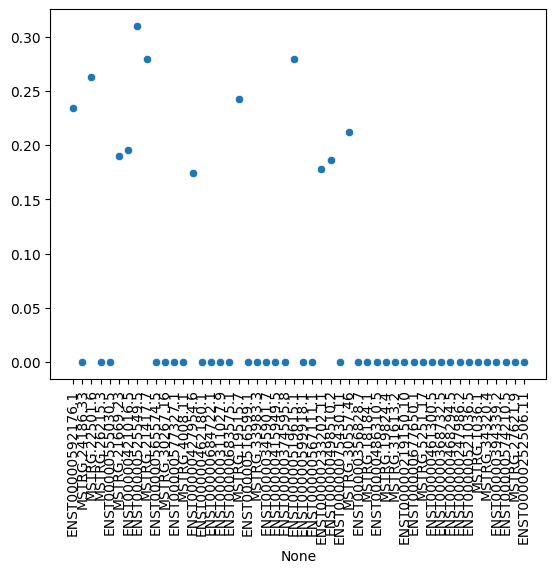

In [ ]:
# plt.figure(figsize=(16,6))
sns.scatterplot(
    y=np.abs(rhos[sorted_corr_ids]), 
    x=data.columns[sorted_corr_ids],
    )
plt.xticks(rotation=90)

In [ ]:
data.columns[sorted_corr_ids], len(sorted_corr_ids) 

(Index(['ENST00000592176.1', 'MSTRG.24186.33', 'MSTRG.22501.6', 'MSTRG.26215.3',
        'ENST00000555030.5', 'MSTRG.21669.23', 'ENST00000421016.5',
        'ENST00000525549.5', 'MSTRG.21417.7', 'ENST00000565574.5',
        'MSTRG.30267.16', 'ENST00000577327.1', 'MSTRG.4008.11',
        'ENST00000427954.6', 'ENST00000462180.1', 'ENST00000684722.1',
        'ENST00000311027.9', 'ENST00000683575.1', 'MSTRG.19515.7',
        'ENST00000516599.1', 'MSTRG.33983.3', 'ENST00000345901.7',
        'ENST00000415949.5', 'ENST00000374595.8', 'ENST00000519615.1',
        'ENST00000599918.1', 'ENST00000567111.1', 'ENST00000233202.11',
        'ENST00000498510.2', 'ENST00000075430.11', 'MSTRG.30557.46',
        'ENST00000356828.7', 'MSTRG.18184.1', 'ENST00000486310.5',
        'MSTRG.19824.4', 'MSTRG.31613.2', 'ENST00000219150.10',
        'ENST00000677650.1', 'MSTRG.5251.17', 'ENST00000461300.5',
        'ENST00000368732.5', 'ENST00000468294.5', 'ENST00000247986.2',
        'ENST00000521036.5', 'MSTR

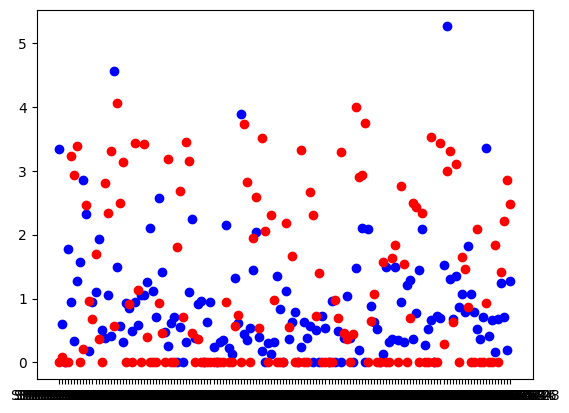

In [ ]:
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]], 'bo')
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]], 'ro')

In [ ]:
data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]]

SRR19147435    3.333235
SRR19147436    0.603373
SRR19147437    0.000000
SRR19147438    1.781958
SRR19147439    0.945340
                 ...   
SRR19147641    0.686215
SRR19147642    1.246514
SRR19147644    0.718699
SRR19147646    0.188776
SRR19147648    1.278190
Name: ENST00000592176.1, Length: 150, dtype: float32

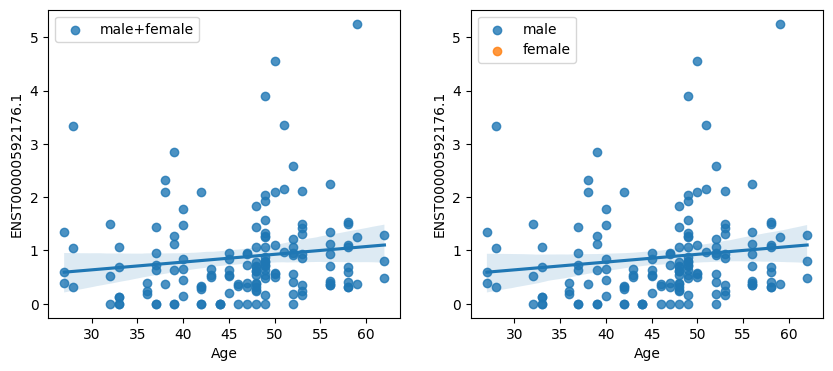

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
            label='male')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
            label='female')
axs[0].legend()
axs[1].legend()

In [ ]:


# n_features = 5
# n_features = -1

# sex = 'male'

print(data.shape[0])

for n_features in range(1, np.min([data.shape[0]+1, len(sorted_corr_ids)+1, 20])):
# for n_features in [5]:

    X = data[data.columns[sorted_corr_ids[:n_features]]].values
    y = data_header['Age'].loc[data_header['sex'] == sex].values

    # print(X.shape)
    print(f"{n_features=}")
    
    # cv = StratifiedKFold(n_splits=5)
    cv = LeaveOneOut()

    preds = []
    vals  = []
    gls_preds = []
    
    rmses = []
    r2s = []

    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]

        # train_scaler = RobustScaler().fit(X_train)
        # test_scaler = RobustScaler().fit(X_test)
        # X_train = train_scaler.transform(X_train)
        # X_test = test_scaler.transform(X_test)

        X_train_ = X_train
        y_train_ = y_train
        X_val = X_test
        y_val = y_test

        # model = svm.SVR(kernel='linear')
        # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
        # model = LinearRegression()
        # model = Ridge()
        model = XGBRegressor()
        # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
        #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
        
        model.fit(X_train_, y_train_)
        pred = model.predict(X_test)
        
        preds.append(pred)
        vals.append(y_val)
                
        X_train_ = sm.add_constant(X_train_)
        X_test = sm.add_constant(X_test, has_constant='add')
        
        mod = sm.GLS(y_train_, X_train_).fit()
        gls_pred = mod.predict(X_test)
        gls_preds.append(gls_pred)
        
        # rmses.append(
        #     RMSE(pred, y_val)
        # )
        # r2s.append(
        #     r2_score(y_val, pred)
        # )

    print("RMSE: ", RMSE(preds, vals))
    # print("RMSE: ", RMSE(gls_preds, vals))
    print("R2: ", r2_score(vals, preds))
    # print("R2: ", r2_score(vals, gls_preds))
    
    # print("RMSE: ", np.mean(rmses))
    # print("R2: ", np.mean(r2s))
    
    print(data.columns[sorted_corr_ids[:n_features]])
    print("-"*20)
    # print(model.coef_)
    # print(model.intercept_)

    # plt.plot(vals, "bo")
    # plt.plot(preds, "ro")
    # plt.show()
    
model.coef_

150
n_features=1


89it [00:02, 31.40it/s]


KeyboardInterrupt: 

In [207]:
n_features = 5

X = data[data.columns[sorted_corr_ids[:n_features]]].values
y = data_header['Age'].loc[data_header['sex'] == sex].values

X_total = X
X_total = RobustScaler().fit_transform(X)

model.fit(X_total, y)
pred = model.predict(X_total)
print(pred)


mod = sm.GLS(y, sm.add_constant(X_total)).fit()
gls_pred = mod.predict(sm.add_constant(X_total))
print(gls_pred)

print("RMSE: ", RMSE(y, pred))
print("RMSE: ", RMSE(y, gls_pred))

print("-"*20)

X_eval = data_eval[data.columns[sorted_corr_ids[:n_features]]]
# X_eval = RobustScaler().fit_transform(X_eval)

y_predicted = model.predict(X_eval)
# print(y_predicted.astype(int), data_eval_header['Age'].values)
# 
y_pred_gls = mod.predict(sm.add_constant(X_eval))
# print(y_pred_gls.astype(int), data_eval_header['Age'].values)

print("RMSE eval: ", RMSE(data_eval_header['Age'].values, y_predicted))
print("RMSE eval: ", RMSE(data_eval_header['Age'].values, y_pred_gls))


print("R2: ", r2_score(data_eval_header['Age'].values, y_predicted))
print("R2: ", r2_score(data_eval_header['Age'].values, y_pred_gls))

# y_predicted = mod.predict(sm.add_constant(X_eval))

[28.000166 26.999939 33.000282 40.004345 44.999504 42.00315  38.99989
 48.99845  38.99971  38.000114 36.002625 55.999634 50.000328 49.000767
 31.99664  36.00004  49.00195  55.998955 50.002457 32.00137  49.99887
 41.99988  47.00662  45.00024  42.99952  37.001137 57.999504 57.996876
 33.000183 58.999367 52.999374 55.995346 48.00081  52.000687 53.0002
 61.999043 47.999756 48.000523 48.99972  37.000206 52.00337  47.99636
 45.99976  57.998894 56.00033  47.999603 52.00006  51.002552 48.99942
 36.9996   51.999413 48.000084 46.001797 58.000416 55.993717 50.996708
 52.999126 40.000576 48.99938  48.003574 48.9991   40.00084  52.99917
 48.99692  48.00433  48.999638 51.999783 48.999744 43.99918  47.000088
 32.999172 28.000204 27.000982 40.00341  42.00077  38.999313 38.002247
 45.000446 49.002228 38.99831  35.99943  48.999474 55.998245 50.000225
 32.00069  49.999737 41.99961  46.999886 45.001003 44.00071  47.001015
 51.998554 49.00266  43.998985 47.000755 27.999538 26.999636 33.000343
 39.99959  44

In [208]:
transcripts = data.columns[sorted_corr_ids[:n_features]]
print(transcripts.values)
print(model.coef_)
gtf_data.loc[transcripts].drop_duplicates()

['ENST00000592176.1' 'MSTRG.24186.33' 'MSTRG.22501.6' 'MSTRG.26215.3'
 'ENST00000555030.5']


AttributeError: Coefficients are not defined for Booster type None

In [209]:
gtf_data.loc[transcripts, 'gene_name'].drop_duplicates().values

array(['APOC1', '', 'ATP5MJ'], dtype=object)

In [210]:
# from ucsc.api import Hub, Genome, Track, TrackSchema, Chromosome, Sequence

# genome = Genome.find('wuhCor1')

# print(genome.genomeName)
# print(genome.organism)
# print(genome.__dict__) # to return all attributes in the object

# track = genome.tracks[0]

# ---------------------------------

# # track = genome.findTrackBy('shortLabel','Microdeletions')
# # (dir(track))
# # sequence = Sequence.get(genome='hg38', chrom='chr1')
# # sequence.dna

# genome = Genome.find('hg38')
# tracks = genome.tracks

# for track in tracks:
#     print(track.trackName)

In [149]:
import requests, json
headers = {"accept": "application/json"}

genes_dict = {}

for gene_name in gtf_data.loc[transcripts, 'gene_name'].drop_duplicates().values: 
    print(f"{gene_name=}")
    url = f"https://www.encodeproject.org/search/?searchTerm={gene_name}"
    
    response = requests.get(url, headers=headers)
    search_results = response.json()
    
    for result in search_results["@graph"]:
        if "organism" in result.keys():
            if (result['organism']['scientific_name'] == 'Homo sapiens'):
                if "name" in result.keys():
                    print(result['name'])
                    print(result['title'])
                    print(result['geneid'])
                    print("-"*10)
                    genes_dict[gene_name] = result
                    break
        else:
            print(result)
            

    # print(search_results["@graph"])

gene_name='SNORA75'
small nucleolar RNA, H/ACA box 75
SNORA75 (Homo sapiens)
654321
----------
gene_name='ENSG00000226905'
gene_name='FAN1'
FANCD2 and FANCI associated nuclease 1
FAN1 (Homo sapiens)
22909
----------
gene_name='MS4A6A'
membrane spanning 4-domains A6A
MS4A6A (Homo sapiens)
64231
----------
gene_name='RGN'
Rho guanine nucleotide exchange factor 28
ARHGEF28 (Homo sapiens)
64283
----------


In [130]:
for key in genes_dict.keys():
    print(genes_dict[key]['geneid'])

654321
22909
64231
64283


In [131]:
from Bio import Entrez


ModuleNotFoundError: No module named 'Bio'

In [132]:
Entrez.email = "zodelheim@gmail.com"
handle = Entrez.einfo() # or esearch, efetch, ...
record = Entrez.read(handle)
handle.close()
record


NameError: name 'Entrez' is not defined

In [133]:
for key in genes_dict.keys():
    print(genes_dict[key]['geneid'])
    handle = Entrez.efetch(db="gene", id=str(genes_dict[key]['geneid']), retmode='xml')
    records = Entrez.parse(handle)
    for record in records:
        if "Entrezgene_summary" in record.keys():
            print(record['Entrezgene_summary'])
        # each record is a Python dictionary or list.
        # print(record.keys())
        print(record['Entrezgene_type'])
        print(key)
        print("-"*10)

    handle.close()

654321


NameError: name 'Entrez' is not defined

In [134]:
genes_dict['SLC9A7P1']

KeyError: 'SLC9A7P1'

In [135]:
# record['Entrezgene_summary']
print(record.keys())
# record['Entrezgene_comments']
# genes_dict[key]['geneid']

NameError: name 'record' is not defined

In [136]:
handle = Entrez.esearch(db='gene', term='PACS2')
records = Entrez.read(handle)
handle.close()

NameError: name 'Entrez' is not defined

In [137]:
records['IdList']

NameError: name 'records' is not defined